# Entrenamiento: Cloud Top Height

Notebook para el entrenamiento del modelo "Cloud Top Height", cuyo trabajo es determinar la altura de las nubes en cada pixel.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [3]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [2]:
trainconfig.preparar_dataset()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

In [4]:
# ------------------------------------------------------------------

lista_keys_X = ["4","6","14","16","Altura","CM"]
lista_keys_y = ["CTH"]

secuenciador_train = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TRAIN,
)

secuenciador_test = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TEST,
)

### Importamos modelo

In [6]:
modelo = modelos.Modelo_CTH()
modelo.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 37, 37, 6)]  0           []                               
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 37, 37, 5)   0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 dense_4 (Dense)                (None, 37, 37, 15)   90          ['tf.__operators__.getitem_3[0][0
                                                                 ]']                              
                                                                                            

### Entrenamos modelo

Epoch 1/50
1366/1366 [==============================] - 98s 71ms/step - loss: 0.0731 - val_loss: 0.0478
Epoch 2/50
1366/1366 [==============================] - 117s 86ms/step - loss: 0.0455 - val_loss: 0.0435
Epoch 3/50
1366/1366 [==============================] - 137s 100ms/step - loss: 0.0424 - val_loss: 0.0415
Epoch 4/50
1366/1366 [==============================] - 148s 109ms/step - loss: 0.0411 - val_loss: 0.0409
Epoch 5/50
1366/1366 [==============================] - 154s 112ms/step - loss: 0.0406 - val_loss: 0.0405
Epoch 6/50
1366/1366 [==============================] - 155s 114ms/step - loss: 0.0404 - val_loss: 0.0403
Epoch 7/50
1366/1366 [==============================] - 161s 118ms/step - loss: 0.0402 - val_loss: 0.0401
Epoch 8/50
1366/1366 [==============================] - 166s 121ms/step - loss: 0.0400 - val_loss: 0.0399
Epoch 9/50
1366/1366 [==============================] - 161s 118ms/step - loss: 0.0399 - val_loss: 0.0398
Epoch 10/50
1366/1366 [==========================

NameError: name 'history' is not defined

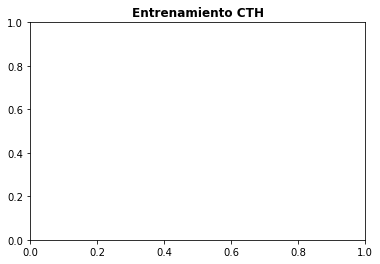

In [7]:
epochs = 50
learning_rate = 0.0004

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
)

try:
    history = modelo.fit(
        secuenciador_train,
        epochs=epochs,
        validation_data=secuenciador_test,
        shuffle=False,
        verbose=1,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento CTH",weight="bold")
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.xlabel("Epoca")
plt.ylabel("loss")
plt.grid()
plt.legend()

### Guardamos pesos

In [17]:
save = False

if save:
    modelo.save_weights(f"{trainconfig.DIR_PESOS}/CTH/pesos.tf",save_format="tf")
    print(f"Pesos guardados en {trainconfig.DIR_PESOS}/CTH/pesos.tf")

## Inspección visual resultados

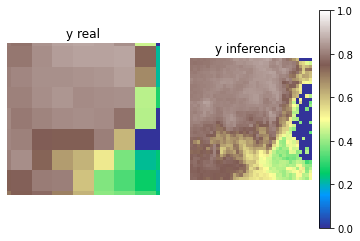

In [15]:
batch = 0
index = 7

x_prueba , y_real = secuenciador_test.__getitem__(batch)

y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_prueba).numpy()
y_inferencia = y_inferencia[index]

fig,ax = plt.subplots(1,2)
for i in range(2): ax[i].axis("off")

ax[0].imshow(y_real,vmin=0,vmax=1,cmap="terrain")
ax[0].set_title("y real")
im = ax[1].imshow(y_inferencia,vmin=0,vmax=1,cmap="terrain")
ax[1].set_title("y inferencia")

plt.colorbar(im)

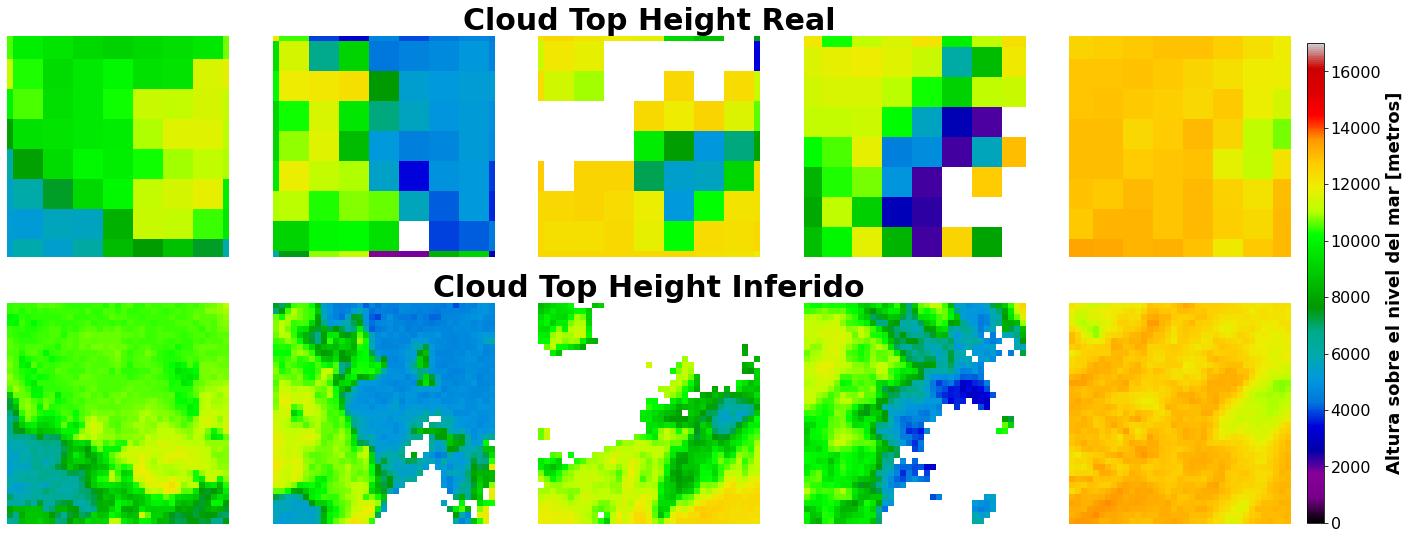

In [53]:
#-----------------------
# Ejemplos de inferencia
#-----------------------
batch = 7

x_real , y_real = secuenciador_test.__getitem__(batch)

# Caracterizamos
lon_batch = x_real.shape[0]
num_ejemplos = 5

# Obtenemos index radom 
index = np.random.randint(0,lon_batch,num_ejemplos)

# Hacemos inferencia
x_real = x_real[index] 
y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_real).numpy()

# Desnormalizamos
vmin,vmax = modelos.normalizacion["CTH"]
y_inferencia = y_inferencia*(vmax-vmin) + vmin
y_real = y_real*(vmax-vmin) + vmin

y_real[y_real == 0] = np.nan
y_inferencia[y_inferencia==0] = np.nan

fig,ax = plt.subplots(2,num_ejemplos,figsize=(4*num_ejemplos + 3,4*2 + 1))
for i in range(num_ejemplos):
    ax[0,i].axis("off")
    ax[1,i].axis("off")
    
    ax[0,i].imshow(y_real[i],vmin=0,vmax=17_000,cmap="nipy_spectral")
    imshow = ax[1,i].imshow(y_inferencia[i],vmin=0,vmax=17_000,cmap="nipy_spectral")
    
ax[0,2].set_title("Cloud Top Height Real",weight="bold",fontsize=30)
ax[1,2].set_title("Cloud Top Height Inferido",weight="bold",fontsize=30)

cax = fig.add_axes([0.91,0.128, 0.01, 0.74])
cb = plt.colorbar(imshow,cax=cax)
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Altura sobre el nivel del mar [metros]',weight='bold',fontsize=18)
